<a href="https://colab.research.google.com/github/Brickhoff/kaggle_data/blob/master/homework3_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: Xuezhang Wu
# UIN: 227000740

In [1]:
# Instantiating the VGG16 convolutional base

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 3s 0us/step


In [2]:
# Displaying a summary of the convolutional base

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
# Extracting features using the pre-trained convolutional base

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'kaggle_data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# The extracted features are currently of shape (samples, 4, 4, 512). We will feed
# them to a densely-connected classifier, so first we must flatten them to (samples,
# 8192)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# At this point, we can define our densely-connected classifier (note the use of dropout
# for regularization), and train it on the data and labels that we just recorded:

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 567us/step - loss: 0.6072 - acc: 0.6705 - val_loss: 0.4400 - val_acc: 0.8410
Epoch 2/30
2000/2000 [==============================] - 1s 356us/step - loss: 0.4373 - acc: 0.8010 - val_loss: 0.3566 - val_acc: 0.8590
Epoch 3/30
2000/2000 [==============================] - 1s 355us/step - loss: 0.3605 - acc: 0.8475 - val_loss: 0.3141 - val_acc: 0.8790
Epoch 4/30
2000/2000 [==============================] - 1s 361us/step - loss: 0.3203 - acc: 0.8615 - val_loss: 0.2924 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 1s 363us/step - loss: 0.2863 - acc: 0.8805 - val_loss: 0.2786 -

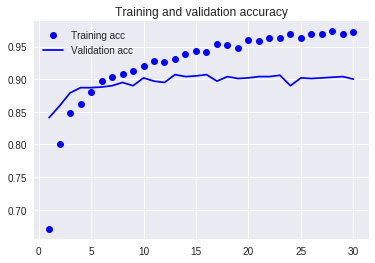

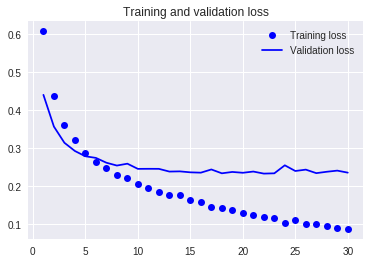

In [4]:
# Plotting our results

import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# Adding a densely-connected classifier on top of the convolutional base

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
# Summary of the extended model

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Freezing the convolutional base
print('This is the number of trainable weights '
     'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [0]:
conv_base.trainable = False

In [9]:
print('This is the number of trainable weights '
     'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [10]:
# Training the model end-to-end with a frozen convolutional base

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(150, 150),
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 28s 278ms/step - loss: 0.6023 - acc: 0.6700 - val_loss: 0.4526 - val_acc: 0.8310
Epoch 2/30
100/100 [==============================] - 26s 259ms/step - loss: 0.4930 - acc: 0.7745 - val_loss: 0.3699 - val_acc: 0.8620
Epoch 3/30
100/100 [==============================] - 26s 256ms/step - loss: 0.4274 - acc: 0.8140 - val_loss: 0.3527 - val_acc: 0.8380
Epoch 4/30
100/100 [==============================] - 26s 256ms/step - loss: 0.4023 - acc: 0.8285 - val_loss: 0.3155 - val_acc: 0.8710
Epoch 5/30
100/100 [==============================] - 26s 256ms/step - loss: 0.3864 - acc: 0.8230 - val_loss: 0.2897 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 26s 265ms/step - loss: 0.3678 - acc: 0.8505 - val_loss: 0.2997 - val_acc: 0.8770
Epoch 7/30
100/100 [==============================] - 25s 251ms/step - loss: 0.3630 - acc: 0.8435 - val_lo

In [0]:
# save the model

model.save('cats_and_dogs_small_3.h5')

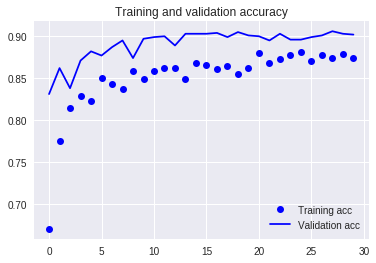

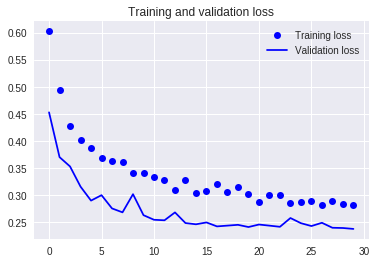

In [12]:
# plot the result again

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
# Displaying a summary of the convolutional base

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
# Freezing all layers up to a specific one

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
# Fine-tuning our model

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 31s 313ms/step - loss: 0.2947 - acc: 0.8805 - val_loss: 0.2356 - val_acc: 0.9100
Epoch 2/100
100/100 [==============================] - 29s 292ms/step - loss: 0.2492 - acc: 0.8915 - val_loss: 0.2177 - val_acc: 0.9100
Epoch 3/100
100/100 [==============================] - 29s 292ms/step - loss: 0.2553 - acc: 0.8945 - val_loss: 0.2230 - val_acc: 0.9130
Epoch 4/100
100/100 [==============================] - 29s 290ms/step - loss: 0.2286 - acc: 0.8975 - val_loss: 0.2007 - val_acc: 0.9260
Epoch 5/100
100/100 [==============================] - 29s 290ms/step - loss: 0.2004 - acc: 0.9145 - val_loss: 0.1845 - val_acc: 0.9290
Epoch 6/100
100/100 [==============================] - 28s 281ms/step - loss: 0.2067 - acc: 0.9155 - val_loss: 0.1954 - val_acc: 0.9210
Epoch 7/100
100/100 [==============================] - 28s 280ms/step - loss: 0.1656 - acc: 0.9360 - val_loss: 0.2291 - val_acc: 0.9210
Epoch 8/100
100/100 [===========================

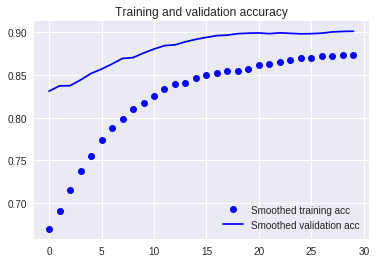

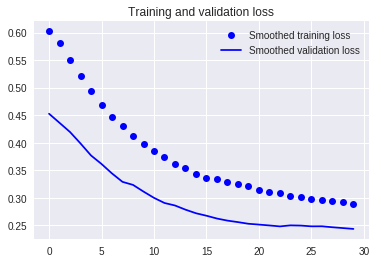

In [16]:
# Smoothing our plots

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
# evaluate this model on the test data

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9319999897480011
